In [7]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import math

import numpy as np
from numpy import asmatrix as mat
from numpy import asarray as arr

import sklearn
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import scipy
from scipy import stats
from scipy.stats import cauchy

In [13]:
import re
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from sklearn.model_selection import train_test_split

def get_IMBD_preprocessing(load_cached=True):
	"""
	Loads IMBD preprocessing according to Pouya's preprocessing.  Gives access to caching functionality to make the 
	process a bit quicker.
	Params:
	---------
	load_cached : bool
	Returns:
	---------
	IMBD train, test, val splits
	"""

	if not load_cached:
		"""
		IMBD preprocessing taken from:
			- https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184
		"""

		reviews_train = []
		for line in open('aclImdb//movie_data/full_train.txt', 'r'):
			reviews_train.append(line.strip())
		reviews_test = []

		for line in open('aclImdb//movie_data/full_test.txt', 'r'):
			reviews_test.append(line.strip())

		REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
		REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

		def preprocess_reviews(reviews):
			reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
			reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
			return reviews

		reviews_train_clean = preprocess_reviews(reviews_train)
		reviews_test_clean = preprocess_reviews(reviews_test)

		cv = CountVectorizer(binary=True)
		cv.fit(reviews_train_clean)
		X = cv.transform(reviews_train_clean)
		X_test = cv.transform(reviews_test_clean)

		target = [1 if i < 12500 else 0 for i in range(25000)]
		X_train, X_val, y_train, y_val = train_test_split(X, target, train_size = 0.999)

		data = {"X_train": X_train, "X_val": X_val, "X_test": X_test, "y_train":y_train, "y_val": y_val, "y_test":target}
		with open('data/data_cache.pickle', 'wb') as handle:
			pickle.dump(data, handle)
	else:
		with open('data/data_cache.pickle', 'rb') as handle:
			data = pickle.load(handle)

	return data

In [4]:
import math

import numpy as np
from numpy import asmatrix as mat
from numpy import asarray as arr

import sklearn
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load preprocessed data
data = get_IMBD_preprocessing(load_cached=True)
X_train, X_val, X_test, y_train, y_val, y_test = \
            data["X_train"], data["X_val"], data["X_test"], data["y_train"], data["y_val"], data["y_test"]

# Basic online kernel learning implementation (no tuning currently)
M, N = X_train.shape
gamma = .0005
n_components = 3750
rbf_feature = np.random.randn(N,n_components)*np.sqrt(gamma)

X_features = X_train.dot(rbf_feature)
X_features = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_features),np.sin(X_features)),axis=1)

clf = LogisticRegression(C=.01, solver='lbfgs')
clf.fit(X_features, y_train)

X_test_prime = X_test.dot(rbf_feature)
X_test_prime = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_test_prime),np.sin(X_test_prime)),axis=1)

print ("Final Accuracy: %s" % accuracy_score(y_test, clf.predict(X_test_prime)))

Final Accuracy: 0.62836


Running: 1000
Running: 2000
Running: 4000
Running: 6000
Running: 8000
Running: 10000
Running: 15000


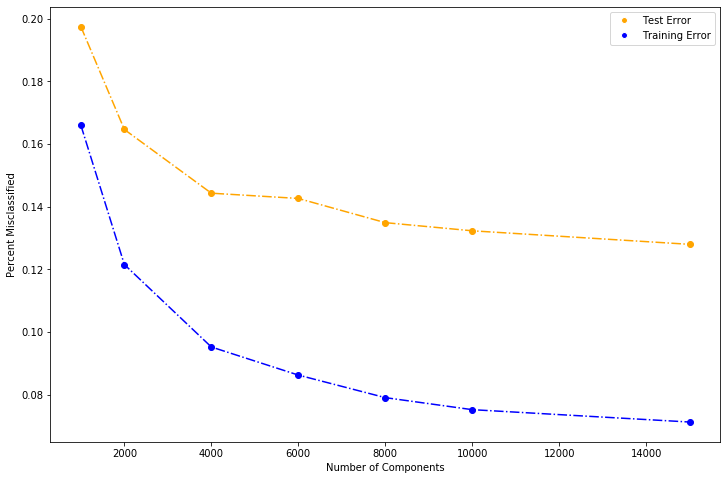

In [6]:
###RBF Kernels
N_COMP = [1000, 2000, 4000, 6000, 8000, 10000, 15000]
test_acc = []
tr_acc = []
for n_components in N_COMP:
    print("Running: {}".format(n_components))
    data = get_IMBD_preprocessing(load_cached=True)
    X_train, X_val, X_test, y_train, y_val, y_test = \
            data["X_train"], data["X_val"], data["X_test"], data["y_train"], data["y_val"], data["y_test"]

    # Basic online kernel learning implementation (no tuning currently)
    M, N = X_train.shape
    gamma = .0005
    rbf_feature = np.random.randn(N,n_components)*np.sqrt(gamma)

    X_features = X_train.dot(rbf_feature)
    X_features = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_features),np.sin(X_features)),axis=1)

    clf = LogisticRegression(C=50, solver='lbfgs', max_iter=2000)
    clf.fit(X_features, y_train)

    X_test_prime = X_test.dot(rbf_feature)
    X_test_prime = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_test_prime),np.sin(X_test_prime)),axis=1)
    
    X_train_prime = X_train.dot(rbf_feature)
    X_train_prime = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_train_prime),np.sin(X_train_prime)),axis=1)

    test_acc.append(1 - accuracy_score(y_test, clf.predict(X_test_prime)))
    tr_acc.append(1 - accuracy_score(y_train, clf.predict(X_train_prime)))
    
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(N_COMP, test_acc, color = 'orange', marker='o', linestyle="-.")
ax.plot(N_COMP, tr_acc, color='blue', marker = 'o', linestyle="-.")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Percent Misclassified")

legend_items = [Line2D([0], [0], marker="o", color="w", 
                markerfacecolor="orange", label="Test Error"),
                Line2D([0], [0], marker="o", color="w", 
                markerfacecolor="blue", label="Training Error")]
    
plt.legend(handles=legend_items)

fig.savefig("../final/figures/rbf.png")

ValueError: x and y must have same first dimension, but have shapes (3,) and (12,)

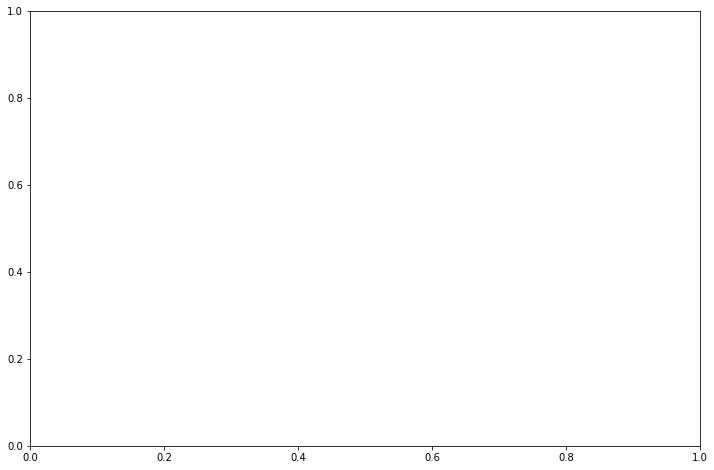

In [15]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(N_COMP, test_acc, color = 'orange', marker='o', linestyle="-.")
ax.plot(N_COMP, tr_acc, color='blue', marker = 'o', linestyle="-.")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Percent Misclassified")

legend_items = [Line2D([0], [0], marker="o", color="w", 
                markerfacecolor="orange", label="Test Error"),
                Line2D([0], [0], marker="o", color="w", 
                markerfacecolor="blue", label="Training Error")]
    
plt.legend(handles=legend_items)

In [9]:
fig.savefig("../final/figures/rbf.png")

Running: 1000
Running: 2000
Running: 4000
Running: 6000
Running: 8000
Running: 10000
Running: 15000


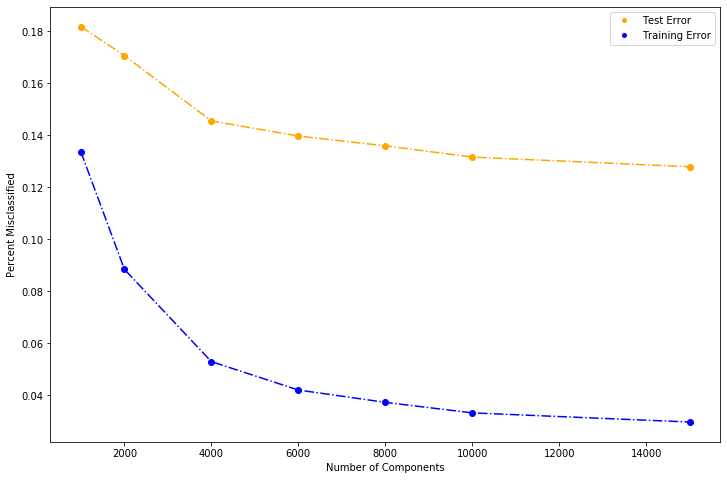

In [9]:
#Cauchy Kernel
N_COMP = [1000, 2000, 4000, 6000, 8000, 10000, 15000]
test_acc = []
tr_acc = []
for n_components in N_COMP:
    print("Running: {}".format(n_components))
    data = get_IMBD_preprocessing(load_cached=True)
    X_train, X_val, X_test, y_train, y_val, y_test = \
            data["X_train"], data["X_val"], data["X_test"], data["y_train"], data["y_val"], data["y_test"]

    # Basic online kernel learning implementation (no tuning currently)
    M, N = X_train.shape
    gamma = .001
    cauchy_feature = stats.cauchy.rvs(0,gamma,(N,n_components))

    X_features = X_train.dot(cauchy_feature)
    X_features = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_features),np.sin(X_features)),axis=1)

    clf = LogisticRegression(C=50, solver='lbfgs', max_iter=2000)
    clf.fit(X_features, y_train)

    X_test_prime = X_test.dot(cauchy_feature)
    X_test_prime = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_test_prime),np.sin(X_test_prime)),axis=1)
    
    X_train_prime = X_train.dot(cauchy_feature)
    X_train_prime = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_train_prime),np.sin(X_train_prime)),axis=1)

    test_acc.append(1 - accuracy_score(y_test, clf.predict(X_test_prime)))
    tr_acc.append(1 - accuracy_score(y_train, clf.predict(X_train_prime)))
    
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(N_COMP, test_acc, color = 'orange', marker='o', linestyle="-.")
ax.plot(N_COMP, tr_acc, color='blue', marker = 'o', linestyle="-.")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Percent Misclassified")

legend_items = [Line2D([0], [0], marker="o", color="w", 
                markerfacecolor="orange", label="Test Error"),
                Line2D([0], [0], marker="o", color="w", 
                markerfacecolor="blue", label="Training Error")]
    
plt.legend(handles=legend_items)
fig.savefig("../final/figures/cauchy.png")

Running: 1000
Running: 2000
Running: 4000
Running: 6000
Running: 8000
Running: 10000
Running: 15000


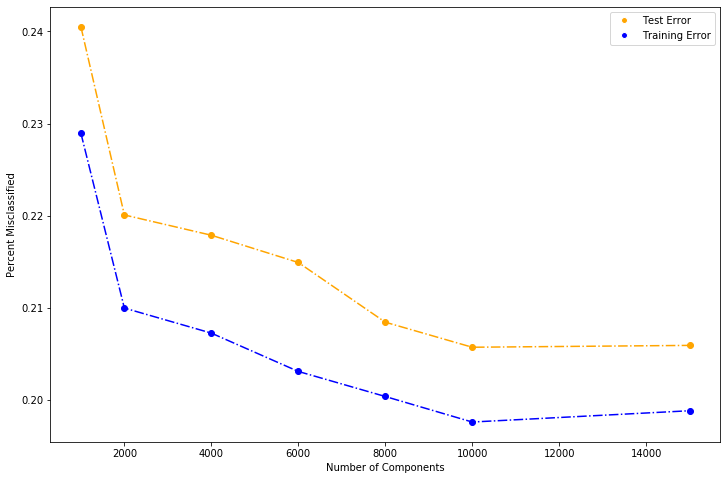

In [10]:
#Laplace Kernel
N_COMP = [1000, 2000, 4000, 6000, 8000, 10000, 15000]
test_acc = []
tr_acc = []
for n_components in N_COMP:
    print("Running: {}".format(n_components))
    data = get_IMBD_preprocessing(load_cached=True)
    X_train, X_val, X_test, y_train, y_val, y_test = \
            data["X_train"], data["X_val"], data["X_test"], data["y_train"], data["y_val"], data["y_test"]

    # Basic online kernel learning implementation (no tuning currently)
    M, N = X_train.shape
    gamma = .001
    laplace_feature = np.random.laplace(0,gamma,(N,n_components))

    X_features = X_train.dot(laplace_feature)
    X_features = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_features),np.sin(X_features)),axis=1)

    clf = LogisticRegression(C=50, solver='lbfgs', max_iter=2000)
    clf.fit(X_features, y_train)

    X_test_prime = X_test.dot(laplace_feature)
    X_test_prime = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_test_prime),np.sin(X_test_prime)),axis=1)
    
    X_train_prime = X_train.dot(laplace_feature)
    X_train_prime = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_train_prime),np.sin(X_train_prime)),axis=1)

    test_acc.append(1 - accuracy_score(y_test, clf.predict(X_test_prime)))
    tr_acc.append(1 - accuracy_score(y_train, clf.predict(X_train_prime)))
    
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(N_COMP, test_acc, color = 'orange', marker='o', linestyle="-.")
ax.plot(N_COMP, tr_acc, color='blue', marker = 'o', linestyle="-.")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Percent Misclassified")

legend_items = [Line2D([0], [0], marker="o", color="w", 
                markerfacecolor="orange", label="Test Error"),
                Line2D([0], [0], marker="o", color="w", 
                markerfacecolor="blue", label="Training Error")]
    
plt.legend(handles=legend_items)
fig.savefig("../final/figures/laplace.png")

Running: 15000
Running: 8000
Running: 8000
Running: 8000
Running: 8000


ValueError: x and y must have same first dimension, but have shapes (7,) and (5,)

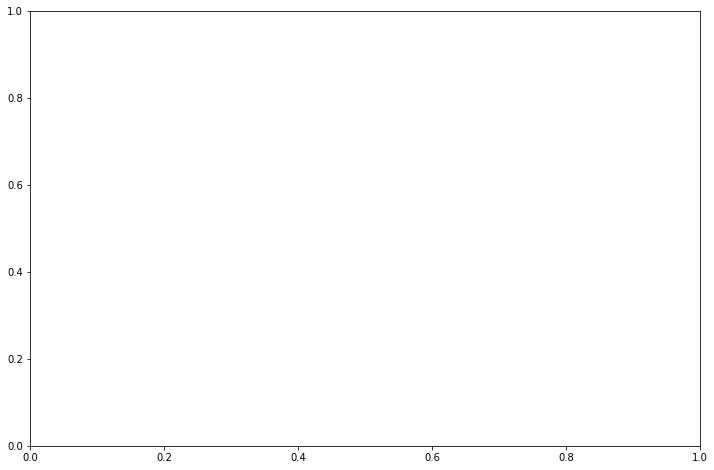

In [11]:
###RBF Kernels -- gamma selection
GAMMA_VALS = [.0001, .0005, .001, .0025, .005]
test_acc = []
tr_acc = []
for gamma in GAMMA_VALS:
    print("Running: {}".format(n_components))
    data = get_IMBD_preprocessing(load_cached=True)
    X_train, X_val, X_test, y_train, y_val, y_test = \
            data["X_train"], data["X_val"], data["X_test"], data["y_train"], data["y_val"], data["y_test"]

    # Basic online kernel learning implementation (no tuning currently)
    M, N = X_train.shape
    n_components = 8000
    rbf_feature = np.random.randn(N,n_components)*np.sqrt(gamma)

    X_features = X_train.dot(rbf_feature)
    X_features = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_features),np.sin(X_features)),axis=1)

    clf = LogisticRegression(C=50, solver='lbfgs', max_iter=2000)
    clf.fit(X_features, y_train)

    X_test_prime = X_test.dot(rbf_feature)
    X_test_prime = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_test_prime),np.sin(X_test_prime)),axis=1)
    
    X_train_prime = X_train.dot(rbf_feature)
    X_train_prime = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_train_prime),np.sin(X_train_prime)),axis=1)

    test_acc.append(1 - accuracy_score(y_test, clf.predict(X_test_prime)))
    tr_acc.append(1 - accuracy_score(y_train, clf.predict(X_train_prime)))
    


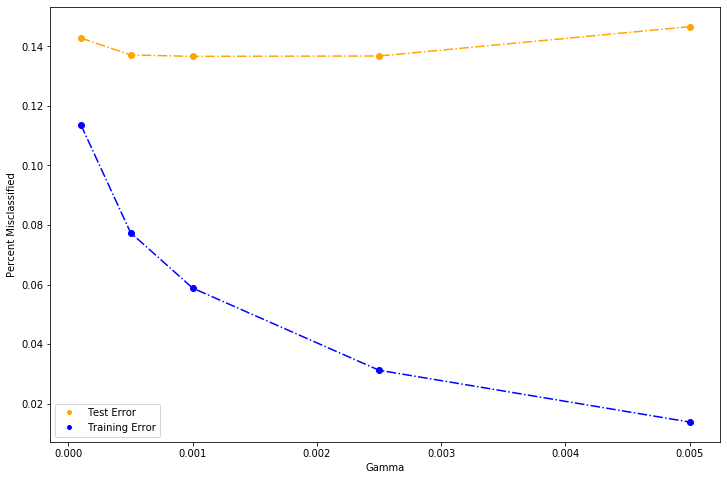

In [12]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(GAMMA_VALS, test_acc, color = 'orange', marker='o', linestyle="-.")
ax.plot(GAMMA_VALS, tr_acc, color='blue', marker = 'o', linestyle="-.")
ax.set_xlabel("Gamma")
ax.set_ylabel("Percent Misclassified")

legend_items = [Line2D([0], [0], marker="o", color="w", 
                markerfacecolor="orange", label="Test Error"),
                Line2D([0], [0], marker="o", color="w", 
                markerfacecolor="blue", label="Training Error")]
    
plt.legend(handles=legend_items)

fig.savefig("../final/figures/gamma.png")

In [14]:

print("Running: {}".format(n_components))
data = get_IMBD_preprocessing(load_cached=True)
X_train, X_val, X_test, y_train, y_val, y_test = \
            data["X_train"], data["X_val"], data["X_test"], data["y_train"], data["y_val"], data["y_test"]

    # Basic online kernel learning implementation (no tuning currently)
M, N = X_train.shape
gamma = 0.001
n_components = 8000
rbf_feature = np.random.randn(N,n_components)*np.sqrt(gamma)

X_features = X_train.dot(rbf_feature)
X_features = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_features),np.sin(X_features)),axis=1)

clf = LogisticRegression(C=50, solver='lbfgs', max_iter=2000)
clf.fit(X_features, y_train)

X_test_prime = X_test.dot(rbf_feature)
X_test_prime = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_test_prime),np.sin(X_test_prime)),axis=1)
    
X_train_prime = X_train.dot(rbf_feature)
X_train_prime = (1/np.sqrt(n_components))*np.concatenate((np.cos(X_train_prime),np.sin(X_train_prime)),axis=1)

print(accuracy_score(y_test, clf.predict(X_test_prime)))
    


Running: 8000
0.8644
